In [1]:
import graph_tool.all as gt
import sys, os
sys.path.insert(0, '..')
import graph_embeddings
from utils.score import statistical_parity
import faiss
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder



Bad key "text.kerning_factor" on line 4 in
/home/ashutosh/miniconda3/envs/study/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
2022-07-31 21:24:47.980381: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-31 21:24:47.980546: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-31 21:24:47.981383: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using 

In [2]:

DATA_FILE = '../data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)

models = {}
window_length = 5
num_walks = 10
dim = 128

models["unbiased"] = graph_embeddings.DeepWalk(window_length=window_length, num_walks=num_walks, restart_prob=0)

models["degree-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80
)

models["group-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

models["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks)
models["fairwalk-group-unbiased"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
)
models['GCN'] = graph_embeddings.GCN()
models["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2)
models["graphsage"] = graph_embeddings.GraphSage()
models["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2)
models["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256])
models["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2)

In [3]:
A[0:].todense(), A.shape

(matrix([[0., 1., 1., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.]]),
 (105, 105))

In [4]:
embs = {}

for k, model in tqdm(models.items()):
    print(model.__class__.__name__)
    sys.stdout = open(os.devnull, 'w')
    emb = model.fit(A).transform(dim=dim)
    sys.stdout = sys.__stdout__
    embs[k] = emb

  9%|██▋                           | 1/11 [00:00<00:01,  7.78it/s]

DeepWalk
residual2vec_sgd



 30%|████▌          | 100/329 [00:00<00:00, 360.31it/s, loss=1.15]


 61%|█████████      | 200/329 [00:00<00:00, 405.55it/s, loss=1.01]


  0%|                          | 0/329 [00:00<?, ?it/s, loss=1.39]


  0%|                          | 0/329 [00:00<?, ?it/s, loss=1.33]

residual2vec_sgd



 30%|████▊           | 100/329 [00:00<00:00, 391.14it/s, loss=1.3]


 61%|█████████      | 200/329 [00:00<00:00, 400.08it/s, loss=1.27]


 36%|██████████▉                   | 4/11 [00:06<00:10,  1.43s/it]

Fairwalk
Fairwalk


 45%|█████████████▋                | 5/11 [00:07<00:05,  1.02it/s]

GCN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-07-31 21:24:55.710871: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-31 21:24:55.729023: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304000000 Hz
 55%|████████████████▎             | 6/11 [00:30<00:42,  8.48s/it]

GCN


 64%|███████████████████           | 7/11 [00:52<00:52, 13.15s/it]

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 73%|█████████████████████▊        | 8/11 [00:57<00:30, 10.30s/it]

GraphSage


 82%|████████████████████████▌     | 9/11 [01:01<00:16,  8.38s/it]

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 91%|██████████████████████████▎  | 10/11 [01:32<00:15, 15.46s/it]

GAT


100%|█████████████████████████████| 11/11 [02:05<00:00, 11.41s/it]


class score:  unbiased 0.17750201253657236
class score:  degree-unbiased 0.15897467745870913
class score:  group-unbiased 0.10880862503647513
class score:  fairwalk 0.1574105322510821
class score:  fairwalk-group-unbiased 0.16964832577100963
class score:  GCN 0.1142979890667961
class score:  gcn-doubleK 0.1672916265225188
class score:  graphsage 0.11755435294386958
class score:  graphsage-doubleK 0.09197097970294793
class score:  gat 0.14452120861541165
class score:  gat-doubleK 0.16037331684692294


In [5]:

def reconstruct_graph(emb, n, m):
    # choose top m edges to reconstruct the graph
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)



In [6]:
n_edges = int(A.sum() / 2)
n_nodes = A.shape[0]
rgraphs = {}
for k, emb in embs.items():
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)

In [7]:
scores = {}
for k, graph in rgraphs.items():
    scores[k] = statistical_parity(graph, group_ids)
    print("class score: ", k, scores[k])

100%|█████████████████████████████| 3/3 [00:00<00:00, 1934.34it/s]


[Text(0,0,'unbiased'),
 Text(0,0,'degree-unbiased'),
 Text(0,0,'group-unbiased'),
 Text(0,0,'fairwalk'),
 Text(0,0,'fairwalk-group-unbiased'),
 Text(0,0,'GCN'),
 Text(0,0,'gcn-doubleK'),
 Text(0,0,'graphsage'),
 Text(0,0,'graphsage-doubleK'),
 Text(0,0,'gat'),
 Text(0,0,'gat-doubleK')]

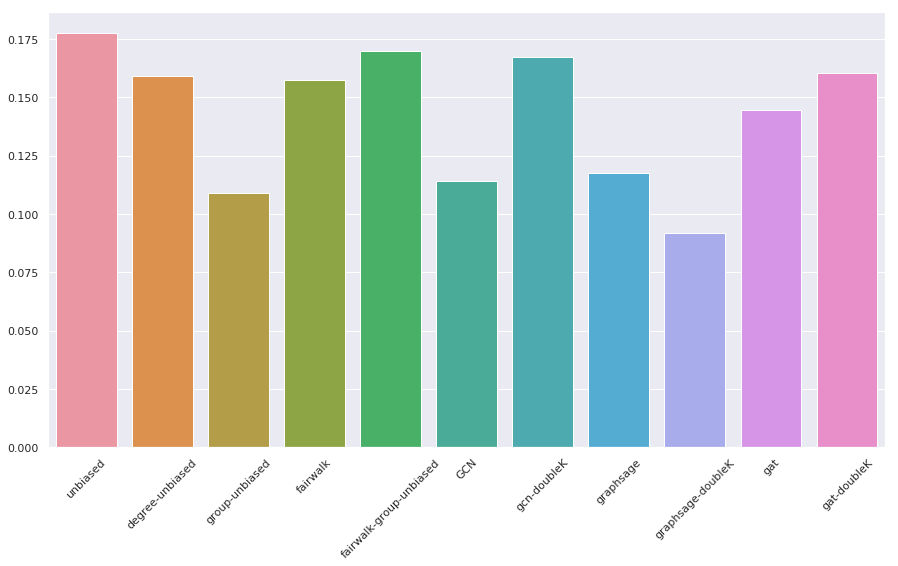

In [8]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [9]:
import pickle as pkl
pkl.dump(rgraphs, open('/tmp/rgraphs.pkl', 'wb'))
pkl.dump(group_ids, open('/tmp/group_ids.pkl', 'wb'))
pkl.dump(embs, open('/tmp/embs.pkl', 'wb'))
